In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import invgamma
import scipy.integrate as integrate
import scipy.optimize as opt
import emcee
import corner

In [2]:
# read the supernova (cosmological) redshift data
datafile = open('SCPUnion2.1_mu_vs_z.txt','r')
SCP_data = pd.read_table(datafile,comment='#',
                        names=['SN name','Redshift','Distance modulus',
                                   'Distance modulus error','P low mass'])
print(SCP_data)

    SN name  Redshift  Distance modulus  Distance modulus error  P low mass
0    1993ah  0.028488         35.346583                0.223906    0.128419
1    1993ag  0.050043         36.682368                0.166829    0.128419
2     1993o  0.052926         36.817691                0.155756    0.128419
3     1993b  0.070086         37.446737                0.158467    0.128419
4    1992bs  0.062668         37.483409                0.156099    0.128419
..      ...       ...               ...                     ...         ...
575   D-000  1.017000         44.293971                0.171046    0.000015
576   D-006  1.315000         44.971358                0.187509    0.551672
577   P-009  0.821000         43.640939                0.194014    0.551672
578   R-012  1.215000         45.246521                0.560317    0.000148
579   Z-005  0.623000         42.514524                0.241428    0.551672

[580 rows x 5 columns]


In [3]:
filename = 'SCPUnion2.1_mu_vs_z.txt'

# Load the data from the file
data = np.loadtxt(filename, usecols=(1, 2, 3, 4), skiprows = 5)
Nd = 580
c = 299792.458 # km/s
alpha = 0.121851859725
beta = 2.46569277393

z = data[:, 0] # size: 580x1
mu = data[:, 1]
mu_error = data[:, 2]
P_low_mass = data[:, 3]
dl = 10**(mu/5-5)
dl_error = 10**(mu/5-5)*(10**(mu_error/5) - 1)

low = z < 0.5

low_z = z[low] # size: 412x1
low_mu = mu[low]
low_mu_error = mu_error[low]
low_P_low_mass = P_low_mass[low]
low_dl = 10**(low_mu/5-5)
low_dl_error = dl_error[low]

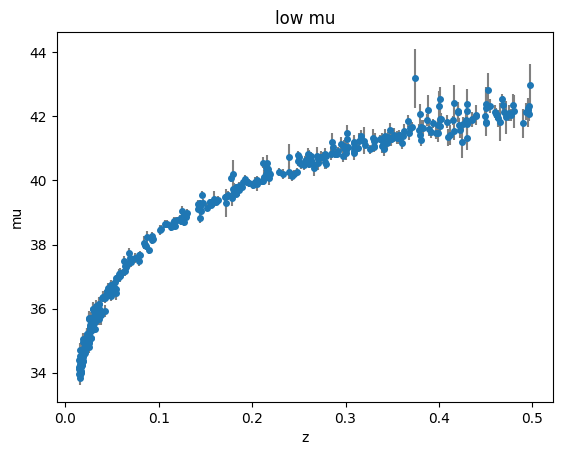

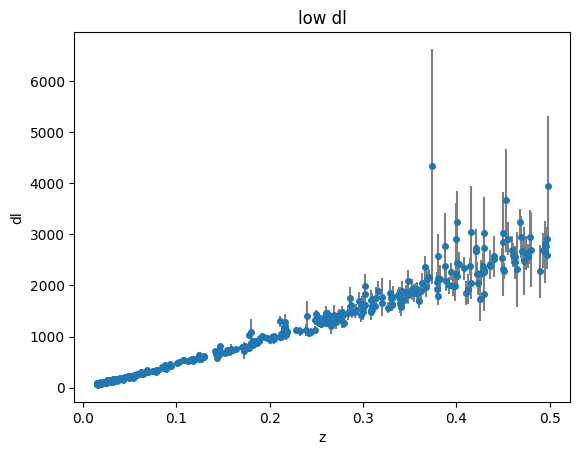

In [4]:
plt.figure(1)
plt.errorbar(low_z, low_mu, yerr=low_mu_error, fmt='o', ecolor='gray', linestyle='None', markersize=4)
plt.xlabel('z')
plt.ylabel('mu')
plt.title('low mu')

plt.show()

plt.figure(2)
plt.errorbar(low_z, low_dl, yerr=low_dl_error, fmt='o', ecolor='gray', linestyle='None', markersize=4)
plt.xlabel('z')
plt.ylabel('dl')
plt.title('low dl')

plt.show()

In [5]:
# Task 1

In [6]:
# Normalized weights.
W = np.square(1/low_dl_error)
Nw = np.sum(W)/412
W = W/Nw

In [7]:
def dl_model(z, H0, q0):
    return c / H0 * (z + 0.5 * (1-q0) * z**2)

In [8]:
def log_likelihood(param, z, dl, W):
    H0, q0, sig2 = param
    n = len(dl)
    return -0.5 * (np.sum((dl - dl_model(z, H0, q0))**2 * W / sig2)) - (n/2) * np.log(2 * np.pi * sig2)

def log_prior(sig2):
    if sig2 > 1e-16:
        return invgamma.logpdf(sig2, a = alpha, scale = beta) 
    else:
        return -np.inf

def log_posterior(param, z, dl, W):
    lp = log_prior(param[-1])
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(param, z, dl, W)
    return ll + lp

In [9]:
def simple_mcmc_analysis(sampler, par, label, burn_in):

    print(f'Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):0.3f}')
    # discard the first 'burn_in' samples 
    
    # thinning means that you only keep every nth sample. E.g. thinning=10 -> keep every 10th sample.
    # This can be useful for reducing long autocorrelation lenghts in a chain. However, thinning is expensive.
    # A thinned chain must be run E.g. 10x longer to reach the desired number of samples.
    # One can argue that thinning is not an advantageous strategy. So keep thinning = 1
    thinning = 1
    flat_mcmc_samples = sampler.get_chain(discard=burn_in,thin=thinning, flat=True)
    print(f'Discarding {nwalkers*burn_in} steps as burn-in')
    print(f'Chain length:{len(flat_mcmc_samples)}')

    fig1 = plt.figure();
    plt.plot(flat_mcmc_samples[:,par],color='gray',alpha=0.7)
    plt.xlabel('Sample');
    plt.ylabel(label)
    plt.xlim(0,len(flat_mcmc_samples));

    return flat_mcmc_samples

In [10]:
ndim, nwalkers = 3, 40
start_pos = [70, -0.4, 251] + 1e-3 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(low_z, low_dl, W))
sampler.run_mcmc(start_pos, 4000, progress=True)

100%|███████████████████████████████████████████████████████████████| 4000/4000 [00:06<00:00, 608.37it/s]


State([[ 70.65942823  -0.50758486 177.64430207]
 [ 69.97152386  -0.33554426 172.14624136]
 [ 70.32232485  -0.42889158 182.12542008]
 [ 70.08036345  -0.33881827 164.63077953]
 [ 70.51625771  -0.48210296 168.90401936]
 [ 69.65286721  -0.26689664 198.11664586]
 [ 70.84044634  -0.48566981 183.28756684]
 [ 70.2545132   -0.49127792 191.38331985]
 [ 70.22070775  -0.44566917 183.0810878 ]
 [ 70.97786726  -0.52767441 169.67121527]
 [ 70.23466577  -0.38802674 177.98438904]
 [ 70.44485664  -0.34945917 160.40442323]
 [ 70.6125995   -0.54881624 167.19669787]
 [ 70.94850131  -0.48781398 160.49490232]
 [ 70.30256457  -0.40117796 183.19934777]
 [ 69.71850252  -0.33265771 188.94372252]
 [ 69.60644634  -0.32303002 197.42290159]
 [ 70.58681458  -0.42469061 183.32356314]
 [ 69.51840287  -0.366983   178.55092338]
 [ 69.8680497   -0.39093491 171.21719441]
 [ 70.32937123  -0.3842371  181.95838885]
 [ 70.38474498  -0.47104139 160.27587699]
 [ 70.40848627  -0.41192231 165.73103555]
 [ 69.93042936  -0.29368634 

Mean acceptance fraction: 0.646
Discarding 20000 steps as burn-in
Chain length:140000


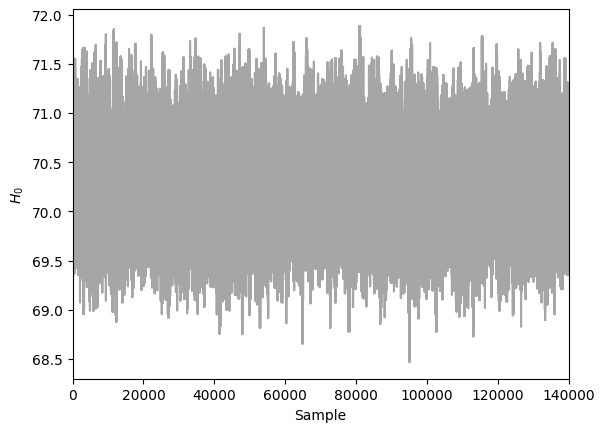

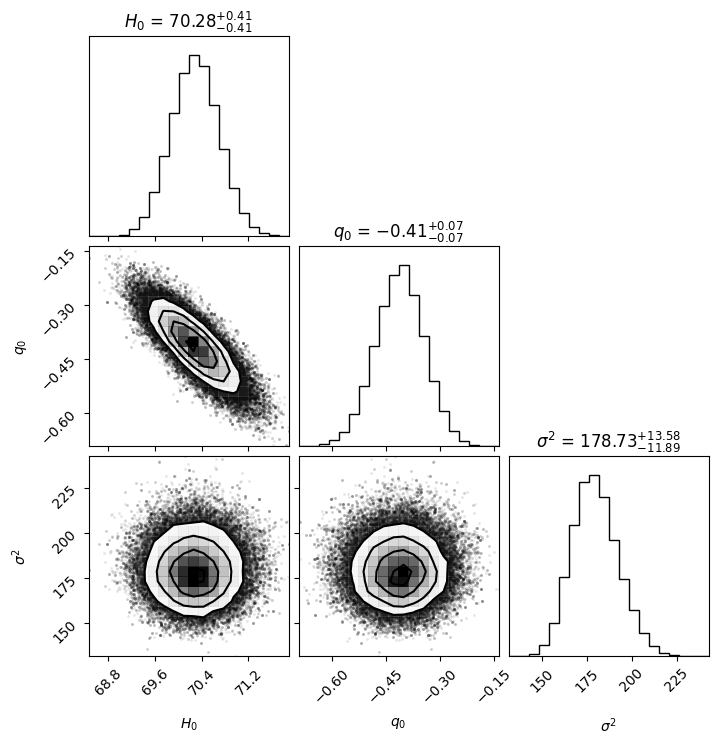

In [11]:
flat_mcmc_samples = simple_mcmc_analysis(sampler, par=0, label=f'$H_0$', burn_in=500)

fig = corner.corner(flat_mcmc_samples,labels=[r"$H_0$", r"$q_0$", r"$\sigma^2$"],show_titles=True)
#plt.savefig('corner_plot.png')

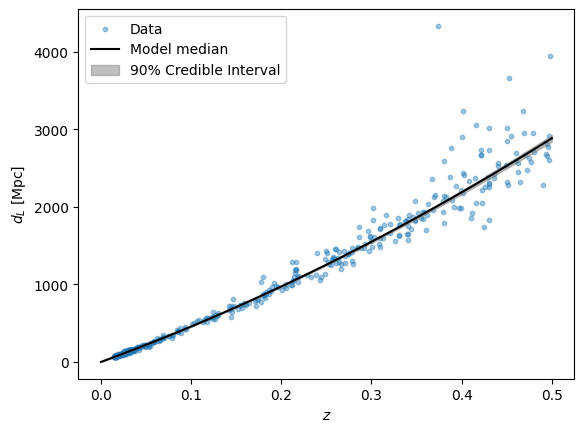

In [12]:
#z_values = np.linspace(0, 0.5, 500)
#z_cherry = low_z[low_dl < 3500]
#dl_cherry = low_dl[low_dl < 3500]

samples = flat_mcmc_samples[:, :2]

# Calculate dl_model values for each sample
dl_samples = np.array([dl_model(z_values, *params) for params in samples])

# Calculate percentiles for the credible interval
lower_bound = np.percentile(dl_samples, 5, axis=0)
upper_bound = np.percentile(dl_samples, 95, axis=0)
median_dl = np.median(dl_samples, axis=0)

# Plotting
plt.figure(3)
plt.scatter(low_z, low_dl, s=10, alpha=0.4, label='Data')
plt.plot(z_values, median_dl, color='black',label='Model median')
plt.fill_between(z_values, lower_bound, upper_bound, color='gray', alpha=0.5, label='90% Credible Interval')
plt.xlabel('$z$')
plt.ylabel('$d_L$ [Mpc]')
plt.legend()
#plt.savefig('PPD.png')
plt.show()

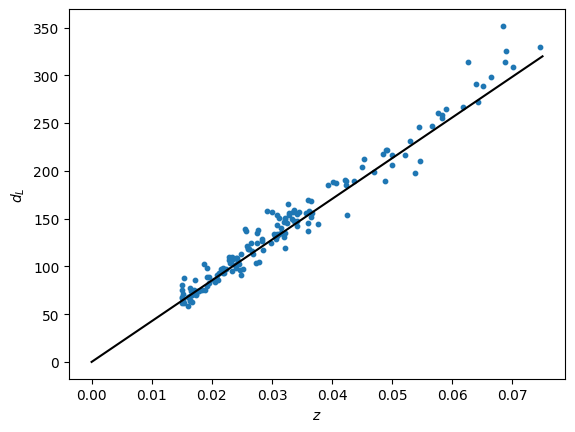

In [13]:
# Check av H0. För z > 0.075 är anpassningen sämre. Endast en term i utvecklingen av dl är här medtagen.

# Medelvärden.
H0_mean, q0_mean, sig2_mean = np.array([np.mean(flat_mcmc_samples[:,k]) for k in range(0,len(flat_mcmc_samples[0]))])
lower_z = low_z[low_z < 0.075]
lower_dl = low_dl[low_z < 0.075]
z_lower_lin = np.linspace(0, 0.075, 500)

plt.figure(4)
plt.scatter(lower_z, lower_dl, s=10)
plt.xlabel('$z$')
plt.ylabel('$d_L$')
plt.plot(z_lower_lin, z_lower_lin*c/H0_mean, color='black')

In [14]:
# Task 2

In [15]:
sorted_indices = np.argsort(z)
sorted_z = z[sorted_indices]
sorted_dl = dl[sorted_indices]

c = 299792.458
H0 = 70

In [16]:
# LCDM and wCDM models.
def E_wCDM(z, Omega_M0, w):
    return Omega_M0*(1+z)**3 + (1-Omega_M0)*(1+z)**(3*(1+w))

def E_LCDM(z, Omega_M0, w):
    return Omega_M0*(1+z)**3 + (1-Omega_M0)

# Eq 15.
def dl_model_full(E, z, Omega_M, w=None):
    dl_values = np.zeros_like(z)
    for i, z_i in enumerate(z):
        integral, _ = integrate.quad(lambda z: 1 / np.sqrt(E(z, Omega_M, w)), 0, z_i)
        dl_values[i] = c * (1 + z_i) / H0 * integral

    return dl_values

In [47]:
def log_likelihood(params, model, z, dl, dl_error):
    if model == 'LCDM':
        Omega_M0 = params[0]
        model = dl_model_full(E_LCDM, z, Omega_M0)
    elif model == 'wCDM':
        Omega_M0, w = params
        model = dl_model_full(E_wCDM, z, Omega_M0, w)

    w = 1 / dl_error**2
    n = len(dl)
    return -0.5 * np.sum((dl - model) ** 2 * w) #+ (n/2)*np.log(2*np.pi*np.sum(dl_error**2))

neg_log_likelihood = lambda *args: -log_likelihood(*args)

In [18]:
# Optimum ΛCDM Model
initial_guess_LCDM = [0.3]  # Initial guess for Omega_M
result_LCDM = opt.minimize(neg_log_likelihood, initial_guess_LCDM, args=('LCDM', z, dl, dl_error))

# Optimum wCDM Model
initial_guess_wCDM = [0.3, -1]  # Initial guesses for Omega_M and w
result_wCDM = opt.minimize(neg_log_likelihood, initial_guess_wCDM, args=('wCDM', z, dl, dl_error))

In [19]:
# BIC and AIC scores. Minus the def. in the lecture notes.
aic_lcdm = (2 * len(initial_guess_LCDM) - 2 * (-result_LCDM.fun))
bic_lcdm = (len(initial_guess_LCDM) * np.log(len(z)) - 2 * (-result_LCDM.fun))

aic_wcdm = (2 * len(initial_guess_wCDM) - 2 * (-result_wCDM.fun))
bic_wcdm = (len(initial_guess_wCDM) * np.log(len(z)) - 2 * (-result_wCDM.fun))

# Results
print(f"AIC for ΛCDM: {aic_lcdm}, BIC for ΛCDM: {bic_lcdm}")
print(f"AIC for wCDM: {aic_wcdm}, BIC for wCDM: {bic_wcdm}")
print(f"Omega_M0 from ΛCDM: {result_LCDM.x}")
print(f"Omega_M0 and w from wCDM: {result_wCDM.x}")

AIC for ΛCDM: 490.2385586555003, BIC for ΛCDM: 494.60158675904074
AIC for wCDM: 492.05783520463575, BIC for wCDM: 500.7838914117167
Omega_M0 from ΛCDM: [0.31339472]
Omega_M0 and w from wCDM: [ 0.28200732 -0.92979608]


In [20]:
def log_prior(Omega_M0):
    if 0.0 <= Omega_M0 <= 1.0:
        return 0.0 
    return -np.inf

def log_posterior(Omega_M0, z, dl, dl_error):
    prior = log_prior(Omega_M0)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(Omega_M0, 'LCDM', z, dl, dl_error)

In [23]:
# MCMC of Omega_M0 of LCDM. Long runtime. Adjust nwalker and nsteps as you like.

ndim = 1
nwalkers = 50
burn_in = 200
initial = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z, dl, dl_error))

nsteps = 2000
sampler.run_mcmc(initial, nsteps, progress=True)

samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))  # Discard first 200 steps as burn-in

100%|████████████████████████████████████████████████████████████████| 2000/2000 [24:33<00:00,  1.36it/s]


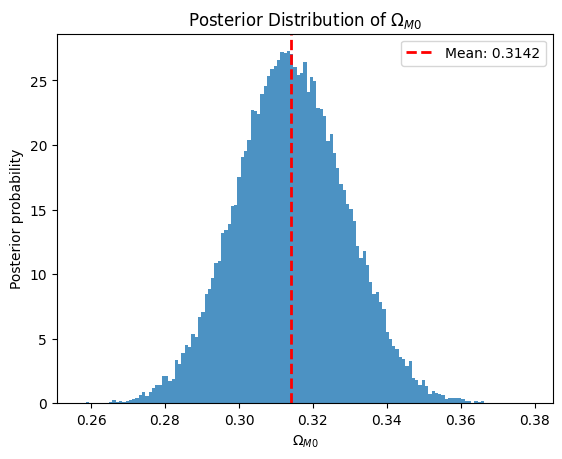

Mean Omega_M0: 0.3141631233257573


In [46]:
mean_Omega_M0 = np.mean(samples[:, 0])
median_Omega_M0 = np.median(samples[:, 0])

hist, bins = np.histogram(samples[:, 0], bins='auto', density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Find the mode
mode_index = np.argmax(hist)
mode_value = bin_centers[mode_index]

plt.figure(4)

# Plotting.
plt.hist(samples[:, 0], density=True, bins=bins, alpha=0.8)
plt.xlabel('$\Omega_{M0}$')
plt.ylabel('Posterior probability')
plt.title('Posterior Distribution of $\Omega_{M0}$')
plt.axvline(mean_Omega_M0, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_Omega_M0:.4f}')
#plt.axvline(median_Omega_M0, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_Omega_M0:.4f}')
#plt.axvline(mode_value, color='yellow', linestyle='dashed', linewidth=2, label=f'Mode: {mode_value:.4f}')
plt.legend()
#plt.savefig('Omega_M0_Distribution.png')
plt.show()

# Print the mean value
print(f"Mean Omega_M0: {mean_Omega_M0}")